River's model yay

# Data Preprocessing

Using tensorflow to split the dataset into training and test data as well as resizing and normalizing images. 

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Define the dataset directory and parameters
data_dir = "./spectrograms"  # dataset path?
batch_size = 32
img_size = (128, 128)  # Resize all images to 224x224

# Load datasets
train_ds, val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # 20% for validation
    subset="both",
    seed=123,  # Ensure reproducibility
    image_size=img_size,
    batch_size=batch_size
)

# val_ds = image_dataset_from_directory(
#     data_dir,
#     validation_split=0.2,
#     subset="validation",
#     seed=123,
#     image_size=img_size,
#     batch_size=batch_size
# )

# Optional: Cache datasets for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Normalize images (scale pixel values to [0, 1])
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


Found 1001 files belonging to 20 classes.
Using 801 files for training.
Using 200 files for validation.


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# define a function for plotting class distribution

def plot_class_distribution(y, title, x_label='Class', y_label='Count', ax=None, y_max_override=None):
    # Dynamically set y_max based on the current input data
    y_max = y_max_override if y_max_override else max(Counter(y).values()) * 1.2

    sns.countplot(x=y, palette='Accent', ax=ax)
    ax.set_title(title)
    ax.set_xlabel(x_label, size=12, color='grey')
    ax.set_ylabel(y_label, size=12, color='grey')
    ax.grid()
    plt.grid(False)

    # Set y-axis limit
    ax.set_ylim(0, y_max)

    # Add percentage text on top of the bars
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2, height + (y_max * 0.025), 
                f'{height/len(y):.2%}', ha='center', color='black', fontsize=10)

In [8]:
# plot the entire dataset
plot_class_distribution(whole_ds.classes, title='Whole Dataset Class Distribution')
plt.show()

NameError: name 'whole_ds' is not defined

C:\Users\rmarshall26\AppData\Local\Temp\ipykernel_3356\585323422.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='Accent', ax=ax)
C:\Users\rmarshall26\AppData\Local\Temp\ipykernel_3356\585323422.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Hate Speech', 'Offensive Language', 'Neither'])
C:\Users\rmarshall26\AppData\Local\Temp\ipykernel_3356\585323422.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='Accent', ax=ax)
C:\Users\rmarshall26\AppData\Local\Temp\ipykernel_3356\585323422.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Hate Speec

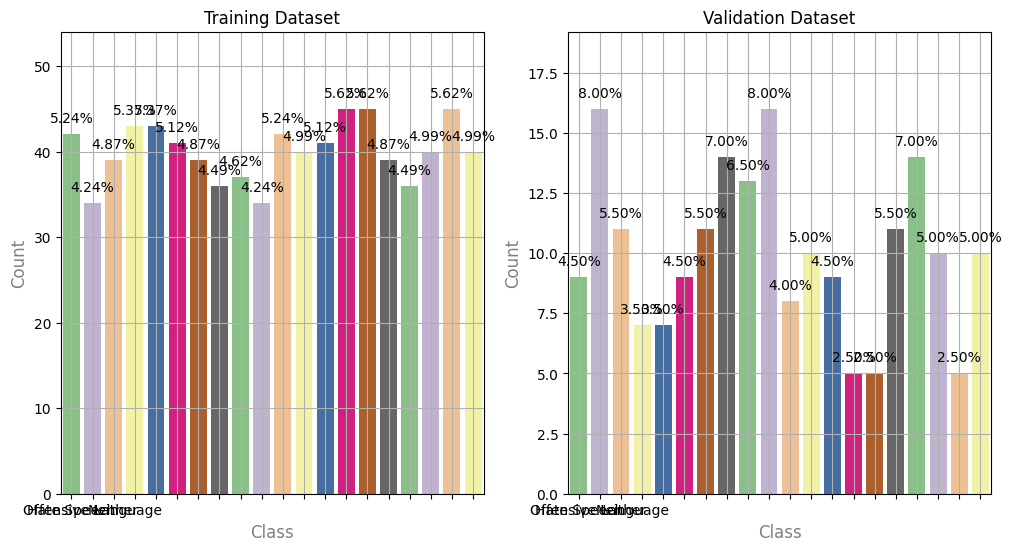

In [7]:
# retrieve training and val labels
train_labels = [label.numpy() for _, label in train_ds.unbatch()]
val_labels = [label.numpy() for _, label in val_ds.unbatch()]

# plot the training dataset class distribution
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_class_distribution(train_labels, title='Training Dataset', ax=ax[0])
plot_class_distribution(val_labels, title='Validation Dataset', ax=ax[1])
plt.show()

# Build CNN Model

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define CNN architecture
def build_cnn(input_shape=(128, 128, 3), num_classes=20):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # Regularization to prevent overfitting
        layers.Dense(num_classes, activation='softmax')  # Output layer
    ])
    return model

# Instantiate the model
num_classes = 20 
model = build_cnn(input_shape=(128, 128, 3), num_classes=num_classes)

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,307,220 (12.62 MB)

 Trainable params: 3,307,220 (12.62 MB)

 Non-trainable params: 0 (0.00 B)

# Train CNN Model

In [27]:
# Define the EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stopping]
)

Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.6332 - loss: 1.1006 - val_accuracy: 0.4050 - val_loss: 2.4762
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.6168 - loss: 1.0335 - val_accuracy: 0.4450 - val_loss: 2.4731
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.6816 - loss: 0.9737 - val_accuracy: 0.4150 - val_loss: 2.5186
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.6724 - loss: 0.9179 - val_accuracy: 0.4250 - val_loss: 2.3469
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.7356 - loss: 0.8336 - val_accuracy: 0.4950 - val_loss: 2.4966
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.7308 - loss: 0.7532 - val_accuracy: 0.4300 - val_loss: 2.6441
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.7593 - loss: 0.6827 - val_accuracy: 0.4500 - val_loss: 2.6561
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.7689 - loss: 0.6677 - val_accuracy: 0.

# Evaluating Model

In [28]:
# Evaluate on the validation set
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc:.2f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4616 - loss: 2.4096
Validation Accuracy: 0.50


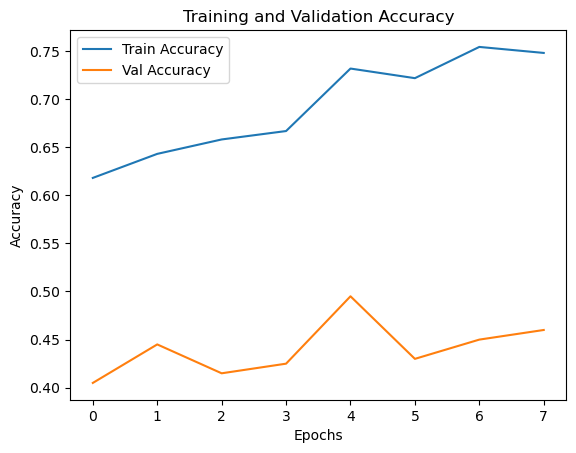

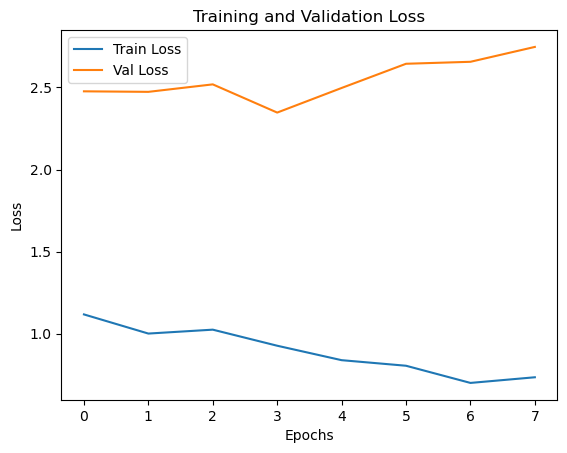

In [29]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()
